In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import ast
from itertools import chain
from collections import Counter
pd.set_option('display.max_columns', None)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
tf.random.set_seed(50)
np.random.seed(50)

df = pd.read_csv("full_set.csv")

### Code to prepare one_hot_df

In [4]:
TARGET_CLASS = "CHM2210"

# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]


final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]

groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_19427/98047007.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_19427/98047007.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').apply(lambd

### code for models (change non max count)

In [5]:
train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 20:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

(9424, 355) (1178, 355) (1179, 355)


In [6]:
# Create pass/fail column
def categorize_grade(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-', 'U', 'W', 
                   'F*', 'D*', 'CF', 'I', 'FF', 'Z', 'W*', 'F+', 'F-', 'F#', 'F*', 'D-*', 'IF', 
                   'IF*', 'D+*', 'CIF', 'Z*', 'IU', 'M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 
                   'IS', 'CW']
    
    # Categorize the grade into one of the four classes
    if grade in fail_grades:
        return 'Fail'
    elif grade.startswith('A'):
        return 'A class'
    elif grade.startswith('B'):
        return 'B class'
    elif grade.startswith('C'):
        return 'C class'
    else:
        return 'Fail'  # Default to Fail if grade doesn't match known categories

#Add columns fro grouped_df
groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(train_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
train_set = train_set.join(groupped_df_filtered[add_columns], )

groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(dev_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
dev_set = dev_set.join(groupped_df_filtered[add_columns], )

# Apply the categorization function
train_set['grade_category'] = train_set['Target_Grade'].apply(categorize_grade)
dev_set['grade_category'] = dev_set['Target_Grade'].apply(categorize_grade)

# Create one-hot encoded columns
train_set = pd.get_dummies(train_set, columns=['grade_category'])
dev_set = pd.get_dummies(dev_set, columns=['grade_category'])

# Ensure that all one-hot encoding columns are present
for col in ['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail']:
    if col not in train_set:
        train_set[col] = 0
    if col not in dev_set:
        dev_set[col] = 0

# # Drop irrelevant columns
X = train_set.drop(columns=['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail', 'Target_Grade'])
X_dev = dev_set.drop(columns=['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail', 'Target_Grade'])

# Drop rows with missing values
X = X.dropna()
X_dev = X_dev.dropna()
X = X.astype('float32')
X_dev = X_dev.astype('float32')

# Extract the target variable (pass/fail)
y = train_set.loc[X.index, ['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail']].values.astype('float32')
y_dev = dev_set.loc[X_dev.index, ['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail']].values.astype('float32')

### Model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(357,)),  # Input layer
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4-class classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

checkpoint = ModelCheckpoint('multiclass_mlp_3l.keras', 
                             monitor='val_categorical_accuracy',  # Monitor validation accuracy
                             save_best_only=True, 
                             mode='max', 
                             verbose=2)

# Train the model with the checkpoint callback
history = model.fit(X, y, 
                    validation_split=0.2,
                    epochs=70, 
                    batch_size=32, 
                    callbacks=[checkpoint])

Epoch 1/70
192/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2847 - loss: 14.7284 
Epoch 1: val_categorical_accuracy improved from -inf to 0.41910, saving model to multiclass_mlp_3l.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.2885 - loss: 12.8356 - val_categorical_accuracy: 0.4191 - val_loss: 1.3881
Epoch 2/70
233/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3278 - loss: 1.5934
Epoch 2: val_categorical_accuracy did not improve from 0.41910
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3278 - loss: 1.5946 - val_categorical_accuracy: 0.2472 - val_loss: 1.7520
Epoch 3/70
196/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3554 - loss: 1.4646
Epoch 3: val_categorical_accuracy did not improve from 0.41910
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3539 - loss: 1.4725 - val_categorical_accuracy: 0.2764 - val_loss: 1.6003
Epoch 4/70
222/236 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - categorical_accuracy: 0.4380 - loss: 1.2066
Loss: 1.1167, Accuracy: 0.4805
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
              precision    recall  f1-score   support

     A class       0.67      0.69      0.68       399
     B class       0.41      0.43      0.42       347
     C class       0.36      0.32      0.34       278
        Fail       0.33      0.34      0.34       154

    accuracy                           0.48      1178
   macro avg       0.44      0.45      0.44      1178
weighted avg       0.48      0.48      0.48      1178



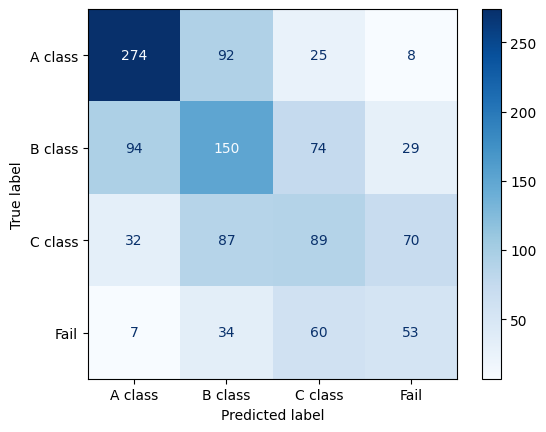

In [11]:
model = load_model('multiclass_mlp_3l.keras')

loss, accuracy = model.evaluate(X_dev, y_dev, batch_size=32)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(X_dev)

# Convert probabilities to predicted class labels (choose the class with highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_dev to class labels for comparison
y_dev_labels = np.argmax(y_dev, axis=1)

# Print classification report for multi-class classification
print(classification_report(y_dev_labels, y_pred, target_names=["A class", "B class", "C class", "Fail"]))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_dev_labels, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["A class", "B class", "C class", "Fail"])
disp.plot(cmap='Blues')

🔍 Loading and evaluating multi-class model...

✅ Loss: 1.1167, Accuracy: 0.4805
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step

📋 Classification Report:
              precision    recall  f1-score   support

     A class       0.67      0.69      0.68       399
     B class       0.41      0.43      0.42       347
     C class       0.36      0.32      0.34       278
        Fail       0.33      0.34      0.34       154

    accuracy                           0.48      1178
   macro avg       0.44      0.45      0.44      1178
weighted avg       0.48      0.48      0.48      1178



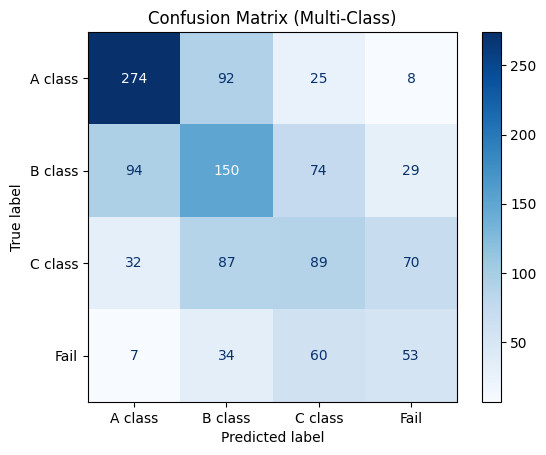


🧠 MODEL COMPLEXITY


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        45,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,094 (930.06 KB)

 Trainable params: 79,364 (310.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 158,730 (620.04 KB)


✅ Total trainable parameters: 79,364
✅ Approximate model size (weights only): 0.30 MB

⚡ INFERENCE PERFORMANCE
• Average inference time (full dev set): 0.0515 seconds
• Per-sample inference time: 0.044 ms

🖼️  SAVING MODEL ARCHITECTURE DIAGRAM
⚠️  Failed to generate diagram: module 'pydot' has no attribute 'InvocationException'
💡 Install with: pip install pydot && install Graphviz system package.


In [13]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and Evaluate Model
# -------------------------------
print("🔍 Loading and evaluating multi-class model...")
model = tf.keras.models.load_model('multiclass_mlp_3l.keras')

loss, accuracy = model.evaluate(X_dev, y_dev, batch_size=32, verbose=0)
print(f"\n✅ Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Predictions
y_pred_probs = model.predict(X_dev, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)
y_dev_labels = np.argmax(y_dev, axis=1)  # assuming y_dev is one-hot encoded

# Classification report
class_names = ["A class", "B class", "C class", "Fail"]
print("\n📋 Classification Report:")
print(classification_report(y_dev_labels, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_dev_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Multi-Class)")
plt.savefig("confusion_matrix_multiclass.png", dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------
# 2. Model Complexity
# -------------------------------
print("\n" + "="*60)
print("🧠 MODEL COMPLEXITY")
print("="*60)
model.summary()

total_params = model.count_params()
model_size_mb = (total_params * 4) / (1024 ** 2)  # float32 = 4 bytes
print(f"\n✅ Total trainable parameters: {total_params:,}")
print(f"✅ Approximate model size (weights only): {model_size_mb:.2f} MB")

# -------------------------------
# 3. Inference Performance
# -------------------------------
print("\n" + "="*60)
print("⚡ INFERENCE PERFORMANCE")
print("="*60)

# Warm-up
_ = model.predict(X_dev[:10], batch_size=32, verbose=0)

# Timed inference (5 runs)
times = []
for _ in range(5):
    start = time.time()
    _ = model.predict(X_dev, batch_size=32, verbose=0)
    end = time.time()
    times.append(end - start)

avg_time = sum(times) / len(times)
per_sample_ms = (avg_time / len(X_dev)) * 1000

print(f"• Average inference time (full dev set): {avg_time:.4f} seconds")
print(f"• Per-sample inference time: {per_sample_ms:.3f} ms")

# -------------------------------
# 4. Save Model Architecture Diagram
# -------------------------------
print("\n" + "="*60)
print("🖼️  SAVING MODEL ARCHITECTURE DIAGRAM")
print("="*60)

try:
    tf.keras.utils.plot_model(
        model,
        to_file="multiclass_model_architecture.png",
        show_shapes=True,
        show_layer_names=True,
        rankdir="TB",
        dpi=120
    )
    if os.path.exists("multiclass_model_architecture.png"):
        print("✅ Model schematic saved as 'multiclass_model_architecture.png'")
    else:
        print("⚠️  Diagram not created (likely missing Graphviz).")
except Exception as e:
    print(f"⚠️  Failed to generate diagram: {e}")
    print("💡 Install with: pip install pydot && install Graphviz system package.")